# Compare Pruning Masks: L1 Norm vs Correlation

This notebook compares masks generated by L1 norm pruning and correlation-based pruning.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import json
import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 6)

In [27]:
# PUBLICATION_STYLE (shared module)
import sys
from pathlib import Path

# Ensure project root (folder containing `src/`) is importable in notebooks
_cwd = Path.cwd().resolve()
_project_root = next((p for p in (_cwd, *_cwd.parents) if (p / "src").exists()), None)
if _project_root is not None and str(_project_root) not in sys.path:
    sys.path.insert(0, str(_project_root))

from src.analysis.plot_style import PUB_COLORS, apply_publication_style, despine

apply_publication_style()

def _despine(ax):
    despine(ax)


In [63]:
from pathlib import Path

# Pick latest runs; override manually if needed
l1_run_dir = Path("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/l1_norm_25_25_25_25_25_25_25_25_25_25_25")
corr_run_dir = Path("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/corr_t85_25_25_25_25_25_25_25_25_25_25_25")

# l1_run_dir = Path("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/l1_norm_50_50_50_50_50_50_50_50_50_50_50")
# corr_run_dir = Path("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/corr_t70_50_50_50_50_50_50_50_50_50_50_50")

# l1_run_dir = Path("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/l1_norm_75_75_75_75_75_75_75_75_75_75_75")
# corr_run_dir = Path("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/corr_t70_75_75_75_75_75_75_75_75_75_75_75")

print("Correlation run:", corr_run_dir)
print("L1 run:", l1_run_dir)

# Sanity checks (fail fast)
if not corr_run_dir.exists():
    raise FileNotFoundError(f"corr_run_dir does not exist: {corr_run_dir}")
if not l1_run_dir.exists():
    raise FileNotFoundError(f"l1_run_dir does not exist: {l1_run_dir}")


Correlation run: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/corr_t85_25_25_25_25_25_25_25_25_25_25_25
L1 run: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/l1_norm_25_25_25_25_25_25_25_25_25_25_25


## Load Pruned Masks

Update the paths to your saved masks.

In [64]:
from pathlib import Path
import torch

def resolve_mask_path(run_dir: Path, filename: str) -> Path:
    """
    Try a few common locations for mask files produced by pruning runs.
    """
    candidates = [
        run_dir / "pruned_model" / filename,
        run_dir / "pruned" / filename,
        run_dir / "masks" / filename,
        run_dir / filename,
    ]
    for p in candidates:
        if p.exists():
            return p
    # default for error reporting
    return candidates[0]


def pick_common_layer(l1_masks: dict, corr_masks: dict, prefer_contains: str | None = None) -> str:
    """
    Pick a layer key that exists in both dicts.
    Optionally prefer keys containing a substring like "encoders.0".
    """
    common = sorted(set(l1_masks.keys()) & set(corr_masks.keys()))
    if not common:
        raise KeyError(
            "No common layer keys between l1_masks and corr_masks.\n"
            f"Example L1 keys: {list(l1_masks.keys())[:10]}\n"
            f"Example Corr keys: {list(corr_masks.keys())[:10]}"
        )

    if prefer_contains:
        preferred = [k for k in common if prefer_contains in k]
        if preferred:
            return preferred[0]

    return common[0]


# --- Load masks ---
l1_mask_path = resolve_mask_path(l1_run_dir, "l1_masks.pt")
corr_mask_path = resolve_mask_path(corr_run_dir, "correlation_masks.pt")

print("L1 mask path:", l1_mask_path)
print("Correlation mask path:", corr_mask_path)

if not l1_mask_path.exists() or not corr_mask_path.exists():
    print("Missing mask file(s). Contents of run dirs:")
    print("L1 run dir:", [p.name for p in l1_run_dir.glob("**/*")][:50])
    print("Corr run dir:", [p.name for p in corr_run_dir.glob("**/*")][:50])
    raise FileNotFoundError("Mask file not found. Check run directory names or prune outputs.")

l1_masks = torch.load(l1_mask_path, map_location="cpu")
corr_masks = torch.load(corr_mask_path, map_location="cpu")

# --- Pick a valid common layer automatically ---
layer_name = pick_common_layer(l1_masks, corr_masks, prefer_contains="encoders.0")

l1_mask = l1_masks[layer_name].detach().cpu().numpy().astype(int)
corr_mask = corr_masks[layer_name].detach().cpu().numpy().astype(int)

print("Layer:", layer_name)
print("L1 Mask shape:", l1_mask.shape)
print("Correlation Mask shape:", corr_mask.shape)
print("L1 kept:", l1_mask.sum(), "/", l1_mask.size)
print("Corr kept:", corr_mask.sum(), "/", corr_mask.size)


L1 mask path: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/l1_norm_25_25_25_25_25_25_25_25_25_25_25/pruned_model/l1_masks.pt
Correlation mask path: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/corr_t85_25_25_25_25_25_25_25_25_25_25_25/pruned_model/correlation_masks.pt
Layer: encoders.0.net.0
L1 Mask shape: (64,)
Correlation Mask shape: (64,)
L1 kept: 48 / 64
Corr kept: 48 / 64


## Visualize Masks Side-by-Side

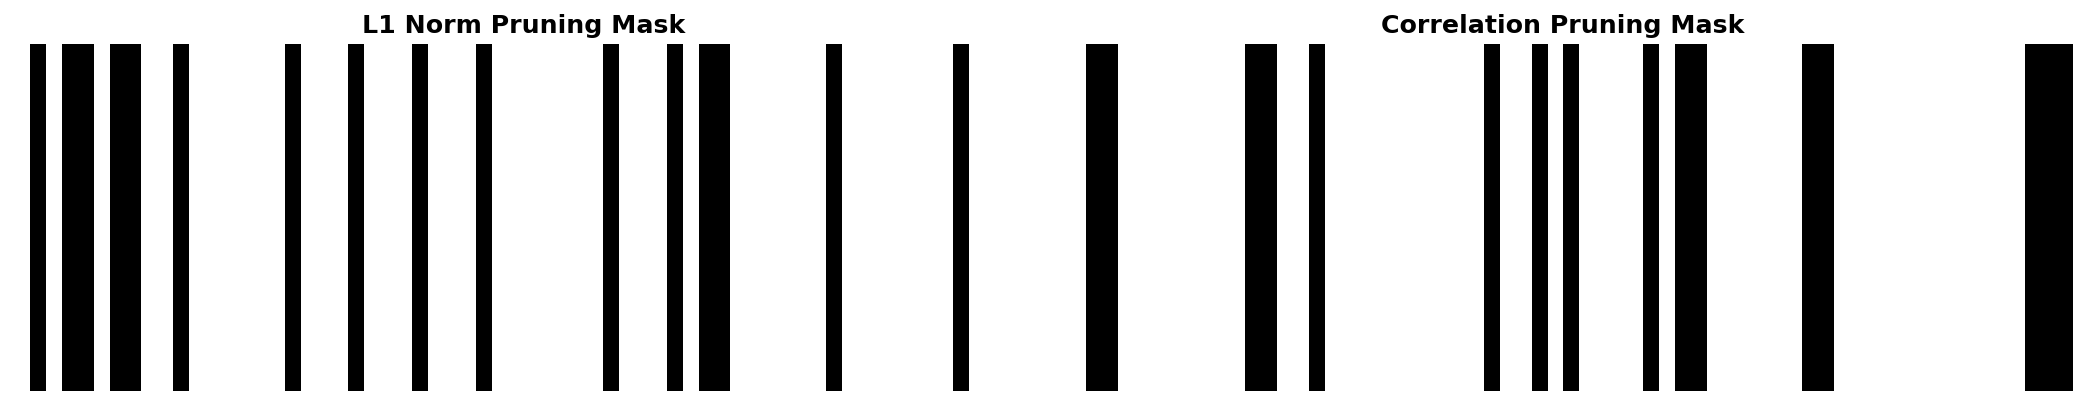

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].imshow(l1_mask[None, :], cmap='gray', aspect='auto')
axes[0].set_title('L1 Norm Pruning Mask')
axes[0].axis('off')

axes[1].imshow(corr_mask[None, :], cmap='gray', aspect='auto')
axes[1].set_title('Correlation Pruning Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Compare Mask Statistics

In [66]:
l1_sparsity = (l1_mask == 0).sum() / l1_mask.size
corr_sparsity = (corr_mask == 0).sum() / corr_mask.size

print("L1 Norm Pruning:")
print(f"  Sparsity: {l1_sparsity:.4f}")
print(f"  Pruned elements: {(l1_mask == 0).sum()}")
print(f"  Kept elements: {(l1_mask != 0).sum()}")

print("\nCorrelation Pruning:")
print(f"  Sparsity: {corr_sparsity:.4f}")
print(f"  Pruned elements: {(corr_mask == 0).sum()}")
print(f"  Kept elements: {(corr_mask != 0).sum()}")

overlap = np.sum((l1_mask != 0) & (corr_mask != 0))
only_l1 = np.sum((l1_mask != 0) & (corr_mask == 0))
only_corr = np.sum((l1_mask == 0) & (corr_mask != 0))

print("\nMask Overlap:")
print(f"  Elements kept by both: {overlap}")
print(f"  Elements only kept by L1: {only_l1}")
print(f"  Elements only kept by Correlation: {only_corr}")

L1 Norm Pruning:
  Sparsity: 0.2500
  Pruned elements: 16
  Kept elements: 48

Correlation Pruning:
  Sparsity: 0.2500
  Pruned elements: 16
  Kept elements: 48

Mask Overlap:
  Elements kept by both: 34
  Elements only kept by L1: 14
  Elements only kept by Correlation: 14


## Visualize Mask Differences

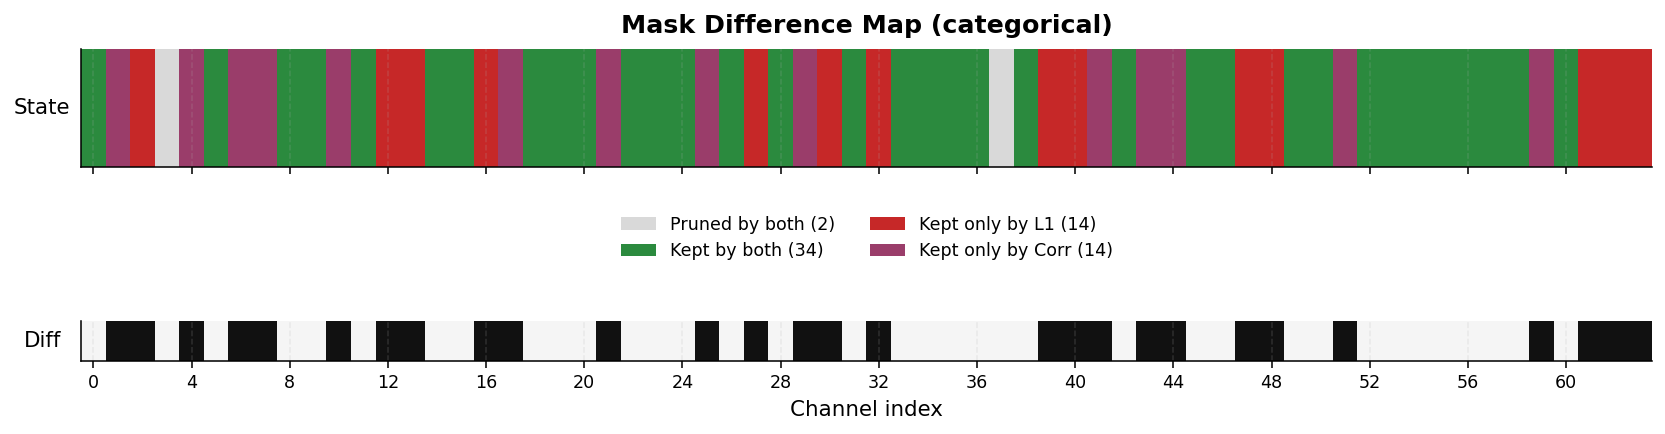

In [67]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# 4 explicit states for clarity
# 0: pruned by both
# 1: kept by both
# 2: kept only by L1
# 3: kept only by Correlation
state = np.zeros(l1_mask.shape, dtype=np.int32)
state[(l1_mask != 0) & (corr_mask != 0)] = 1
state[(l1_mask != 0) & (corr_mask == 0)] = 2
state[(l1_mask == 0) & (corr_mask != 0)] = 3

# Top row: full categorical map
state_row = state[None, :]

# Bottom row: mismatch emphasis (1 where methods differ)
mismatch_row = ((state == 2) | (state == 3)).astype(np.int32)[None, :]

cmap_state = ListedColormap([
    '#D9D9D9',          # pruned by both (light gray)
    PUB_COLORS['good'], # kept by both
    PUB_COLORS['warn'], # kept only by L1
    PUB_COLORS['corr'], # kept only by Corr
])
cmap_mismatch = ListedColormap(['#F5F5F5', '#111111'])

fig, axes = plt.subplots(
    2, 1,
    figsize=(12, 3.2),
    sharex=True,
    gridspec_kw={'height_ratios': [3.0, 1.0]},
)

ax = axes[0]
ax.imshow(state_row, aspect='auto', cmap=cmap_state, vmin=0, vmax=3, interpolation='nearest')
ax.set_title('Mask Difference Map (categorical)', pad=8)
ax.set_yticks([])
ax.set_ylabel('State', rotation=0, labelpad=20, va='center')
_despine(ax)

ax2 = axes[1]
ax2.imshow(mismatch_row, aspect='auto', cmap=cmap_mismatch, vmin=0, vmax=1, interpolation='nearest')
ax2.set_yticks([])
ax2.set_ylabel('Diff', rotation=0, labelpad=20, va='center')
ax2.set_xlabel('Channel index')
_despine(ax2)

step = max(1, l1_mask.size // 16)
ax2.set_xticks(np.arange(0, l1_mask.size, step))

n_pruned_both = int(np.sum(state == 0))
n_kept_both = int(np.sum(state == 1))
n_l1_only = int(np.sum(state == 2))
n_corr_only = int(np.sum(state == 3))

handles = [
    Patch(facecolor='#D9D9D9', edgecolor='none', label=f'Pruned by both ({n_pruned_both})'),
    Patch(facecolor=PUB_COLORS['good'], edgecolor='none', label=f'Kept by both ({n_kept_both})'),
    Patch(facecolor=PUB_COLORS['warn'], edgecolor='none', label=f'Kept only by L1 ({n_l1_only})'),
    Patch(facecolor=PUB_COLORS['corr'], edgecolor='none', label=f'Kept only by Corr ({n_corr_only})'),
]
ax.legend(handles=handles, loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.28))

plt.tight_layout()
plt.show()


## Compare Rebuilt Models

In [68]:
def load_run_summary(run_dir: Path) -> dict:
    p1 = run_dir / "run_summary.json"
    p2 = run_dir / "pruned_model" / "run_summary.json"
    path = p1 if p1.exists() else p2
    if not path.exists():
        raise FileNotFoundError(f"Missing run_summary.json in {run_dir}")
    return json.loads(path.read_text())

def get_pruned_model_path(run_dir: Path) -> Path:
    summary = load_run_summary(run_dir)
    return Path(summary["prune"]["artifacts"]["pruned_model"])

corr_model_path = get_pruned_model_path(corr_run_dir)
l1_model_path = get_pruned_model_path(l1_run_dir)

print("Correlation pruned model:", corr_model_path)
print("L1 pruned model:", l1_model_path)

Correlation pruned model: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/corr_t85_25_25_25_25_25_25_25_25_25_25_25/pruned_model/pruned_model.pth
L1 pruned model: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/pruned/l1_norm_25_25_25_25_25_25_25_25_25_25_25/pruned_model/pruned_model.pth


In [69]:
def load_state_dict(path: Path) -> dict:
    return torch.load(path, map_location="cpu")

corr_sd = load_state_dict(corr_model_path)
l1_sd = load_state_dict(l1_model_path)

corr_keys = set(corr_sd.keys())
l1_keys = set(l1_sd.keys())

print("Keys only in correlation:", sorted(corr_keys - l1_keys)[:10])
print("Keys only in L1:", sorted(l1_keys - corr_keys)[:10])

common_keys = sorted(corr_keys & l1_keys)
shape_mismatches = []
stat_diffs = []

for k in common_keys:
    a = corr_sd[k]
    b = l1_sd[k]
    if a.shape != b.shape:
        shape_mismatches.append((k, tuple(a.shape), tuple(b.shape)))
        continue
    
    # Skip non-floating point tensors (e.g., BN num_batches_tracked)
    if not a.dtype.is_floating_point or a.numel() == 0:
        continue
    
    a_mean, a_std = float(a.mean()), float(a.std())
    b_mean, b_std = float(b.mean()), float(b.std())
    stat_diffs.append((k, abs(a_mean - b_mean), abs(a_std - b_std)))

print("Shape mismatches:", shape_mismatches[:10])
stat_diffs = sorted(stat_diffs, key=lambda x: (x[1] + x[2]), reverse=True)
print("Top stat diffs (key, |meanΔ|, |stdΔ|):")
for row in stat_diffs[:10]:
    print(row)

Keys only in correlation: []
Keys only in L1: []
Shape mismatches: []
Top stat diffs (key, |meanΔ|, |stdΔ|):
('decoders.1.net.1.running_var', 744928.0, 5533456.0)
('decoders.5.net.1.running_var', 366584.0, 1196585.5)
('decoders.3.net.1.running_var', 36872.25, 38556.1875)
('decoders.1.net.4.running_var', 6898.23046875, 2715.111328125)
('decoders.5.net.4.running_var', 5311.333984375, 515.814453125)
('encoders.4.net.4.running_var', 687.7890625, 355.704833984375)
('bottleneck.net.4.running_var', 841.28662109375, 157.696533203125)
('decoders.3.net.4.running_var', 699.839599609375, 196.91162109375)
('encoders.4.net.1.running_var', 334.796875, 205.6845703125)
('encoders.3.net.4.running_var', 359.61962890625, 164.8447265625)


In [70]:
# Baseline state_dict (original channel space) for importance calculations
def get_baseline_ckpt_path(run_dir: Path) -> Path:
    summary = load_run_summary(run_dir)
    return Path(summary['prune']['checkpoints']['baseline_ckpt'])

baseline_ckpt_path = get_baseline_ckpt_path(l1_run_dir)
baseline_sd = torch.load(baseline_ckpt_path, map_location='cpu')
print('Baseline ckpt:', baseline_ckpt_path)


Baseline ckpt: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp78_compare_methods/baseline/training/final_model.pth


In [71]:
def read_resize_log(run_dir: Path) -> list | None:
    summary = load_run_summary(run_dir)
    path = summary["prune"]["artifacts"].get("resize_log")
    if not path:
        return None
    p = Path(path)
    if not p.exists():
        return None
    return json.loads(p.read_text())

corr_resize = read_resize_log(corr_run_dir)
l1_resize = read_resize_log(l1_run_dir)

print("Correlation resize log entries:", 0 if corr_resize is None else len(corr_resize))
print("L1 resize log entries:", 0 if l1_resize is None else len(l1_resize))

if corr_resize:
    print("Correlation resize sample:", corr_resize[:3])
if l1_resize:
    print("L1 resize sample:", l1_resize[:3])

Correlation resize log entries: 0
L1 resize log entries: 0


## List All Layer Names

In [72]:
print("=== All Layer Names in State Dict ===\n")
print("Common keys (in both models):")
common_keys = sorted(corr_keys & l1_keys)
for i, key in enumerate(common_keys, 1):
    print(f"{i:3d}. {key}")

print(f"\n✓ Total common layers: {len(common_keys)}")

=== All Layer Names in State Dict ===

Common keys (in both models):
  1. bottleneck.net.0.weight
  2. bottleneck.net.1.bias
  3. bottleneck.net.1.num_batches_tracked
  4. bottleneck.net.1.running_mean
  5. bottleneck.net.1.running_var
  6. bottleneck.net.1.weight
  7. bottleneck.net.3.weight
  8. bottleneck.net.4.bias
  9. bottleneck.net.4.num_batches_tracked
 10. bottleneck.net.4.running_mean
 11. bottleneck.net.4.running_var
 12. bottleneck.net.4.weight
 13. decoders.0.bias
 14. decoders.0.weight
 15. decoders.1.net.0.weight
 16. decoders.1.net.1.bias
 17. decoders.1.net.1.num_batches_tracked
 18. decoders.1.net.1.running_mean
 19. decoders.1.net.1.running_var
 20. decoders.1.net.1.weight
 21. decoders.1.net.3.weight
 22. decoders.1.net.4.bias
 23. decoders.1.net.4.num_batches_tracked
 24. decoders.1.net.4.running_mean
 25. decoders.1.net.4.running_var
 26. decoders.1.net.4.weight
 27. decoders.2.bias
 28. decoders.2.weight
 29. decoders.3.net.0.weight
 30. decoders.3.net.1.bias
 31

## Compare Single Channel Weights

In [73]:
# Pick a layer and channel to inspect
layer_key = "encoders.0.net.4.bias"   # TODO: choose a layer present in both
channel_idx = 0  # output channel index to compare
num_shown = 100  # how many weights to print per channel

if layer_key not in corr_sd or layer_key not in l1_sd:
    print(f"Layer {layer_key} not found in one or both models.")
else:
    corr_w = corr_sd[layer_key]
    l1_w = l1_sd[layer_key]
    
    if channel_idx >= corr_w.shape[0] or channel_idx >= l1_w.shape[0]:
        print(f"Channel {channel_idx} out of range.")
    else:
        corr_ch = corr_w[channel_idx].numpy().flatten()
        l1_ch = l1_w[channel_idx].numpy().flatten()
        
        print(f"Layer: {layer_key}, Channel: {channel_idx}")
        print(f"\nCorrelation weights (first {num_shown}):\n{corr_ch[:num_shown]}")
        print(f"\nL1 weights (first {num_shown}):\n{l1_ch[:num_shown]}")
        print(f"\nShape corr: {corr_w[channel_idx].shape}, L1: {l1_w[channel_idx].shape}")
        print(f"Abs diff mean: {np.abs(corr_ch - l1_ch).mean():.6f}")
        print(f"Max abs diff: {np.abs(corr_ch - l1_ch).max():.6f}")

Layer: encoders.0.net.4.bias, Channel: 0

Correlation weights (first 100):
[-0.26180393]

L1 weights (first 100):
[-0.26180393]

Shape corr: torch.Size([]), L1: torch.Size([])
Abs diff mean: 0.000000
Max abs diff: 0.000000


## Advanced Layer/Block Diagnostics
These diagnostics compare mask overlap and pruning aggressiveness across all Conv2d layers, not just a single selected layer.

In [74]:
import pandas as pd

def iter_prunable_layers_from_masks(l1_masks, corr_masks):
    names = sorted(set(l1_masks.keys()) | set(corr_masks.keys()))
    for n in names:
        if 'final_conv' in n:
            continue
        if not (n.endswith('.net.0') or n.endswith('.net.3')):
            continue
        yield n

def layer_to_block(name: str) -> str:
    parts = name.split('.')
    if parts[0] == 'bottleneck':
        return 'bottleneck'
    if len(parts) >= 2:
        return '.'.join(parts[:2])
    return parts[0]

rows = []
for layer in iter_prunable_layers_from_masks(l1_masks, corr_masks):
    l1 = l1_masks.get(layer)
    corr = corr_masks.get(layer)
    if l1 is None or corr is None:
        continue

    l1 = l1.cpu().numpy().astype(bool)
    corr = corr.cpu().numpy().astype(bool)

    if l1.shape != corr.shape:
        rows.append({
            'layer': layer, 'block': layer_to_block(layer), 'shape_mismatch': True,
            'shape_l1': tuple(l1.shape), 'shape_corr': tuple(corr.shape)
        })
        continue

    keep_l1 = int(l1.sum())
    keep_corr = int(corr.sum())
    total = int(l1.size)
    prune_l1 = total - keep_l1
    prune_corr = total - keep_corr

    set_l1 = set(np.where(l1)[0].tolist())
    set_corr = set(np.where(corr)[0].tolist())
    inter = len(set_l1 & set_corr)
    union = len(set_l1 | set_corr)
    jaccard = inter / union if union > 0 else np.nan

    # Disagreement on important channels using |weights| from L1 model
    w_key = layer + '.weight'
    topk_pruned_by_corr_frac = np.nan
    if w_key in l1_sd and l1_sd[w_key].ndim >= 1:
        w = l1_sd[w_key].detach().cpu().numpy()
        l1_importance = np.abs(w).reshape(w.shape[0], -1).sum(axis=1)
        k = max(1, prune_corr)
        topk = np.argsort(l1_importance)[::-1][:k]
        topk_pruned_by_corr_frac = float((~corr[topk]).sum() / len(topk))

    rows.append({
        'layer': layer,
        'block': layer_to_block(layer),
        'shape_mismatch': False,
        'total': total,
        'keep_l1': keep_l1,
        'keep_corr': keep_corr,
        'prune_l1': prune_l1,
        'prune_corr': prune_corr,
        'prune_ratio_l1': prune_l1 / total,
        'prune_ratio_corr': prune_corr / total,
        'keep_intersection': inter,
        'keep_union': union,
        'keep_jaccard': jaccard,
        'topk_l1_pruned_by_corr_frac': topk_pruned_by_corr_frac,
    })

layer_df = pd.DataFrame(rows).sort_values(['block', 'layer']).reset_index(drop=True)
display(layer_df.head(20))
print(f'Layers compared: {len(layer_df)}')
print('Mean kept-channel Jaccard:', round(layer_df['keep_jaccard'].dropna().mean(), 4))


,layer,block,shape_mismatch,total,keep_l1,keep_corr,prune_l1,prune_corr,prune_ratio_l1,prune_ratio_corr,keep_intersection,keep_union,keep_jaccard,topk_l1_pruned_by_corr_frac
0,bottleneck.net.0,bottleneck,False,1024,768,768,256,256,0.25,0.25,571,965,0.591710,0.226562
1,bottleneck.net.3,bottleneck,False,1024,768,768,256,256,0.25,0.25,553,983,0.562564,0.234375
2,decoders.1.net.0,decoders.1,False,512,384,384,128,128,0.25,0.25,291,477,0.610063,0.226562
3,decoders.1.net.3,decoders.1,False,512,384,384,128,128,0.25,0.25,283,485,0.583505,0.257812
4,decoders.3.net.0,decoders.3,False,512,384,384,128,128,0.25,0.25,290,478,0.606695,0.250000
5,decoders.3.net.3,decoders.3,False,512,384,384,128,128,0.25,0.25,296,472,0.627119,0.218750
6,decoders.5.net.0,decoders.5,False,256,192,192,64,64,0.25,0.25,142,242,0.586777,0.234375
7,decoders.5.net.3,decoders.5,False,256,192,192,64,64,0.25,0.25,130,254,0.511811,0.296875
8,decoders.7.net.0,decoders.7,False,128,96,96,32,32,0.25,0.25,72,120,0.600000,0.250000
9,decoders.7.net.3,decoders.7,False,128,96,96,32,32,0.25,0.25,69,123,0.560976,0.250000


Layers compared: 22
Mean kept-channel Jaccard: 0.6111


In [75]:
# Block-level aggregation
valid = layer_df[~layer_df['shape_mismatch']].copy()
block_df = valid.groupby('block', as_index=False).agg(
    total=('total', 'sum'),
    keep_l1=('keep_l1', 'sum'),
    keep_corr=('keep_corr', 'sum'),
    prune_l1=('prune_l1', 'sum'),
    prune_corr=('prune_corr', 'sum'),
    keep_jaccard_mean=('keep_jaccard', 'mean'),
    topk_l1_pruned_by_corr_frac_mean=('topk_l1_pruned_by_corr_frac', 'mean'),
)
block_df['prune_ratio_l1'] = block_df['prune_l1'] / block_df['total']
block_df['prune_ratio_corr'] = block_df['prune_corr'] / block_df['total']
display(block_df.sort_values('block'))

# Most divergent layers
div = valid.assign(
    prune_ratio_gap=(valid['prune_ratio_corr'] - valid['prune_ratio_l1']).abs(),
    disagreement=(1.0 - valid['keep_jaccard'])
).sort_values(['prune_ratio_gap', 'disagreement'], ascending=False)
display(div[['layer', 'block', 'prune_ratio_l1', 'prune_ratio_corr', 'keep_jaccard', 'topk_l1_pruned_by_corr_frac']].head(15))


,block,total,keep_l1,keep_corr,prune_l1,prune_corr,keep_jaccard_mean,topk_l1_pruned_by_corr_frac_mean,prune_ratio_l1,prune_ratio_corr
0,bottleneck,2048,1536,1536,512,512,0.577137,0.230469,0.25,0.25
1,decoders.1,1024,768,768,256,256,0.596784,0.242188,0.25,0.25
2,decoders.3,1024,768,768,256,256,0.616907,0.234375,0.25,0.25
3,decoders.5,512,384,384,128,128,0.549294,0.265625,0.25,0.25
4,decoders.7,256,192,192,64,64,0.580488,0.250000,0.25,0.25
5,decoders.9,128,96,96,32,32,0.573770,0.187500,0.25,0.25
6,encoders.0,128,96,96,32,32,0.646921,0.281250,0.25,0.25
7,encoders.1,256,192,192,64,64,0.674122,0.234375,0.25,0.25
8,encoders.2,512,384,384,128,128,0.648555,0.257812,0.25,0.25
9,encoders.3,1024,768,768,256,256,0.613623,0.261719,0.25,0.25


,layer,block,prune_ratio_l1,prune_ratio_corr,keep_jaccard,topk_l1_pruned_by_corr_frac
7,decoders.5.net.3,decoders.5,0.25,0.25,0.511811,0.296875
12,encoders.0.net.0,encoders.0,0.25,0.25,0.548387,0.312500
9,decoders.7.net.3,decoders.7,0.25,0.25,0.560976,0.250000
1,bottleneck.net.3,bottleneck,0.25,0.25,0.562564,0.234375
10,decoders.9.net.0,decoders.9,0.25,0.25,0.573770,0.312500
11,decoders.9.net.3,decoders.9,0.25,0.25,0.573770,0.062500
3,decoders.1.net.3,decoders.1,0.25,0.25,0.583505,0.257812
6,decoders.5.net.0,decoders.5,0.25,0.25,0.586777,0.234375
14,encoders.1.net.0,encoders.1,0.25,0.25,0.586777,0.187500
20,encoders.4.net.0,encoders.4,0.25,0.25,0.590062,0.203125


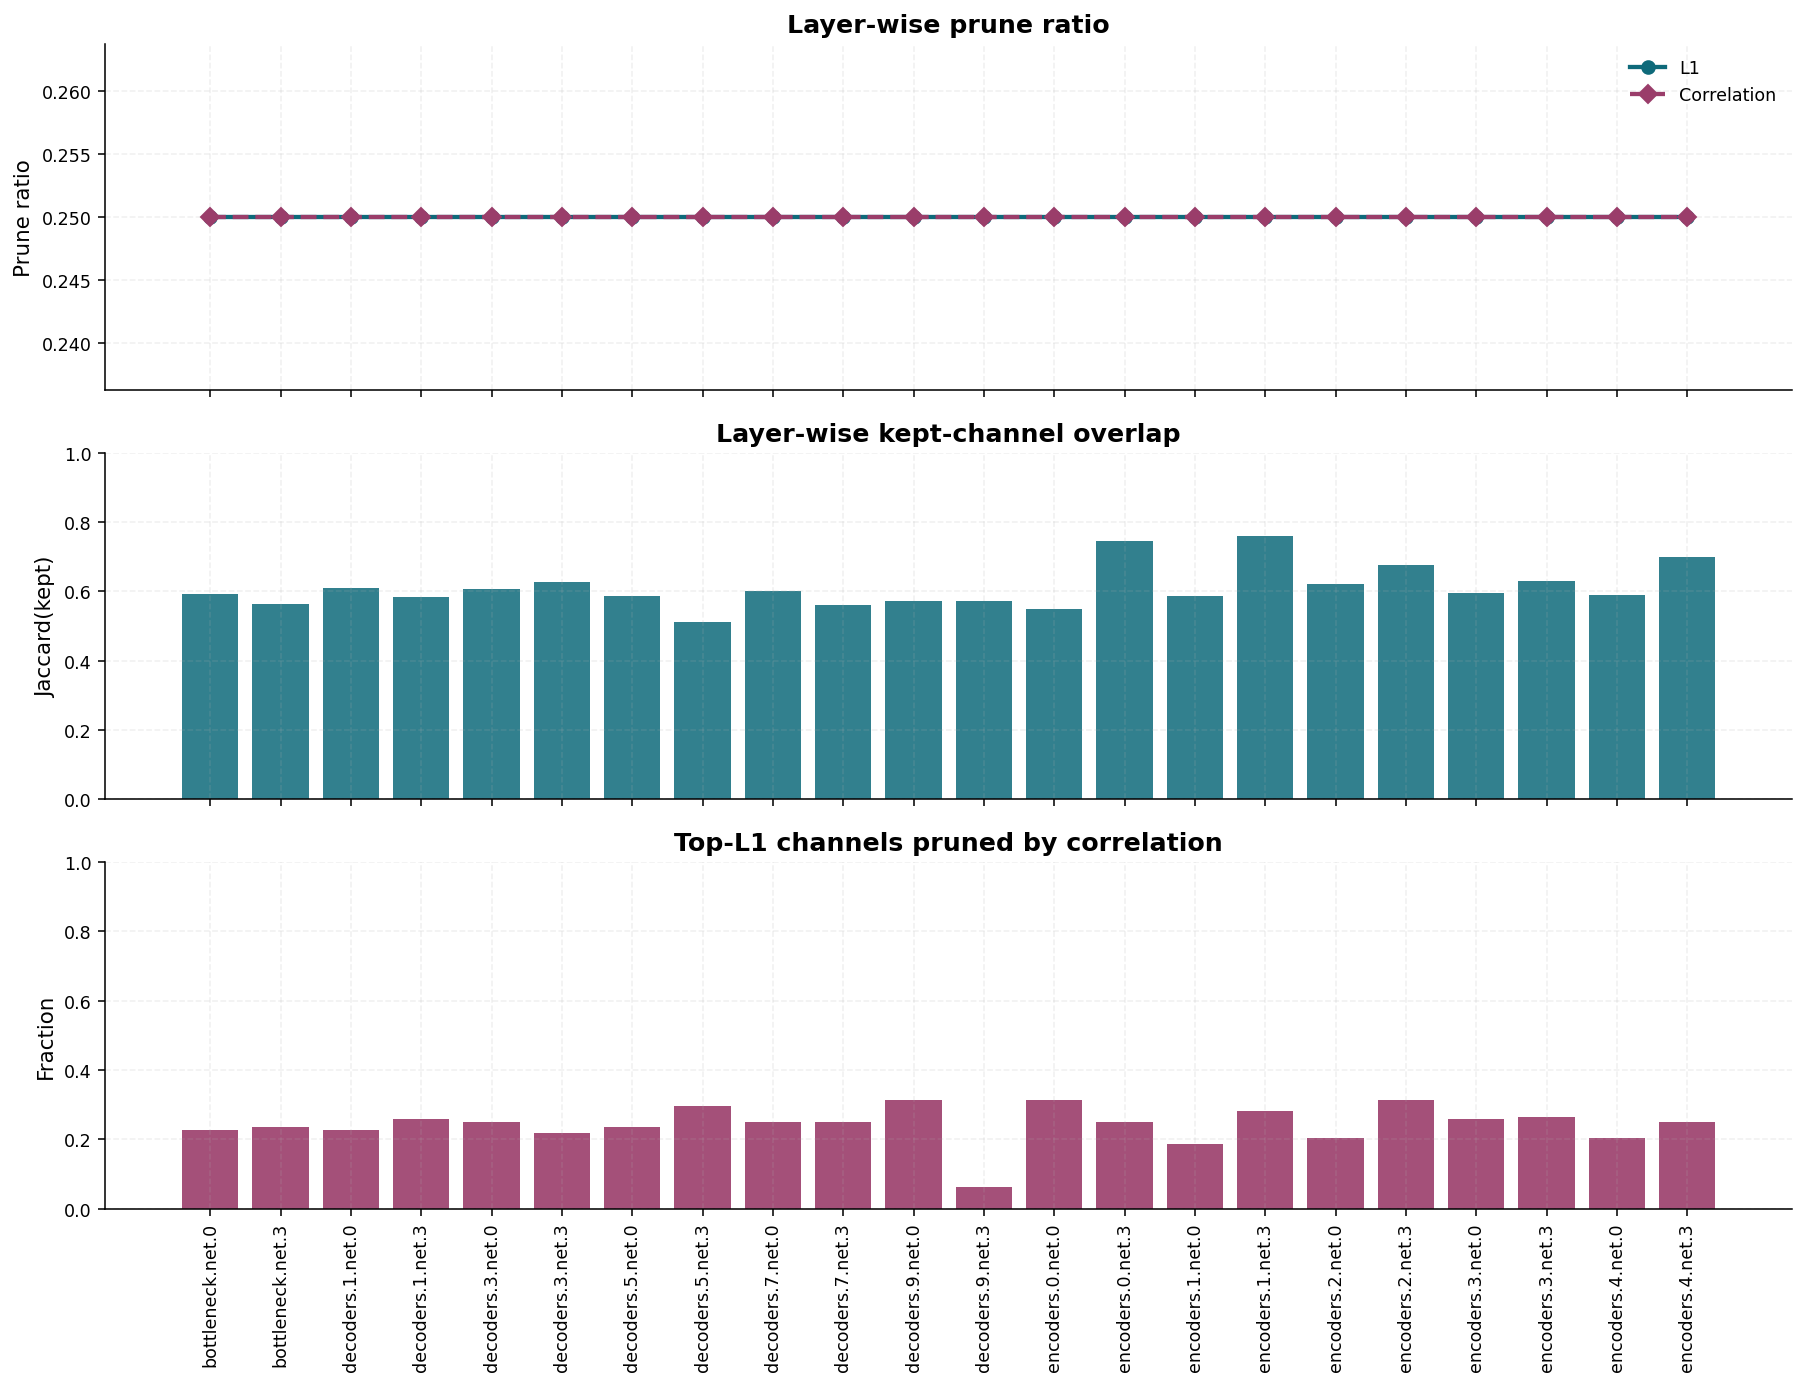

In [76]:
# Quick plots (publication style)
fig, axes = plt.subplots(3, 1, figsize=(13, 10), sharex=True)
x = np.arange(len(valid))
labels = valid['layer'].tolist()

axes[0].plot(x, valid['prune_ratio_l1'], marker='o', ms=6.5, lw=2.2, linestyle='-', color=PUB_COLORS['l1'], label='L1')
axes[0].plot(x, valid['prune_ratio_corr'], marker='D', ms=6.5, lw=2.2, linestyle='--', color=PUB_COLORS['corr'], label='Correlation')
axes[0].set_ylabel('Prune ratio')
axes[0].set_title('Layer-wise prune ratio')
axes[0].legend(frameon=False)
_despine(axes[0])

axes[1].bar(x, valid['keep_jaccard'], color=PUB_COLORS['l1'], alpha=0.85)
axes[1].set_ylabel('Jaccard(kept)')
axes[1].set_title('Layer-wise kept-channel overlap')
axes[1].set_ylim(0, 1)
_despine(axes[1])

axes[2].bar(x, valid['topk_l1_pruned_by_corr_frac'], color=PUB_COLORS['corr'], alpha=0.9)
axes[2].set_ylabel('Fraction')
axes[2].set_title('Top-L1 channels pruned by correlation')
axes[2].set_ylim(0, 1)
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels, rotation=90)
_despine(axes[2])

plt.tight_layout()
plt.show()


In [42]:
# Optional: save diagnostics for report/reuse
out_dir = exp_dir / 'analysis' / 'mask_compare'
out_dir.mkdir(parents=True, exist_ok=True)
layer_df.to_csv(out_dir / 'mask_compare_layer.csv', index=False)
block_df.to_csv(out_dir / 'mask_compare_block.csv', index=False)
print('Saved:', out_dir / 'mask_compare_layer.csv')
print('Saved:', out_dir / 'mask_compare_block.csv')


Saved: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp72_partial_corr_acdc_new/analysis/mask_compare/mask_compare_layer.csv
Saved: /mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp72_partial_corr_acdc_new/analysis/mask_compare/mask_compare_block.csv


## Extra Comparison Diagnostics
Additional plots to diagnose where correlation pruning diverges from L1.

In [43]:
# Ensure working tables exist and enforce architecture order
if 'valid' not in globals():
    valid = layer_df[~layer_df['shape_mismatch']].copy()

def _layer_order_key(name: str):
    parts = name.split('.')
    if parts[0] == 'encoders':
        blk = int(parts[1])
        conv = int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else 0
        return (0, blk, conv, name)
    if parts[0] == 'bottleneck':
        conv = int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else 0
        return (1, 0, conv, name)
    if parts[0] == 'decoders':
        blk = int(parts[1])
        conv = int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else 0
        return (2, blk, conv, name)
    return (99, 0, 0, name)

valid = valid.copy()
valid['prune_ratio_gap'] = (valid['prune_ratio_corr'] - valid['prune_ratio_l1']).abs()
valid['disagreement'] = 1.0 - valid['keep_jaccard']
valid = valid.sort_values('layer', key=lambda s: s.map(_layer_order_key)).reset_index(drop=True)

display(valid[['layer','block','prune_ratio_l1','prune_ratio_corr','prune_ratio_gap','keep_jaccard','topk_l1_pruned_by_corr_frac']].head(12))
print(f'Ordered layers: {len(valid)}')


,layer,block,prune_ratio_l1,prune_ratio_corr,prune_ratio_gap,keep_jaccard,topk_l1_pruned_by_corr_frac
0,encoders.0.net.0,encoders.0,0.5,0.5,0.0,0.306122,0.437500
1,encoders.0.net.3,encoders.0,0.5,0.5,0.0,0.523810,0.437500
2,encoders.1.net.0,encoders.1,0.5,0.5,0.0,0.376344,0.500000
3,encoders.1.net.3,encoders.1,0.5,0.5,0.0,0.620253,0.500000
4,encoders.2.net.0,encoders.2,0.5,0.5,0.0,0.319588,0.476562
5,encoders.2.net.3,encoders.2,0.5,0.5,0.0,0.306122,0.476562
6,encoders.3.net.0,encoders.3,0.5,0.5,0.0,0.322997,0.496094
7,encoders.3.net.3,encoders.3,0.5,0.5,0.0,0.299492,0.496094
8,encoders.4.net.0,encoders.4,0.5,0.5,0.0,0.319588,0.457031
9,encoders.4.net.3,encoders.4,0.5,0.5,0.0,0.276808,0.457031


Ordered layers: 22


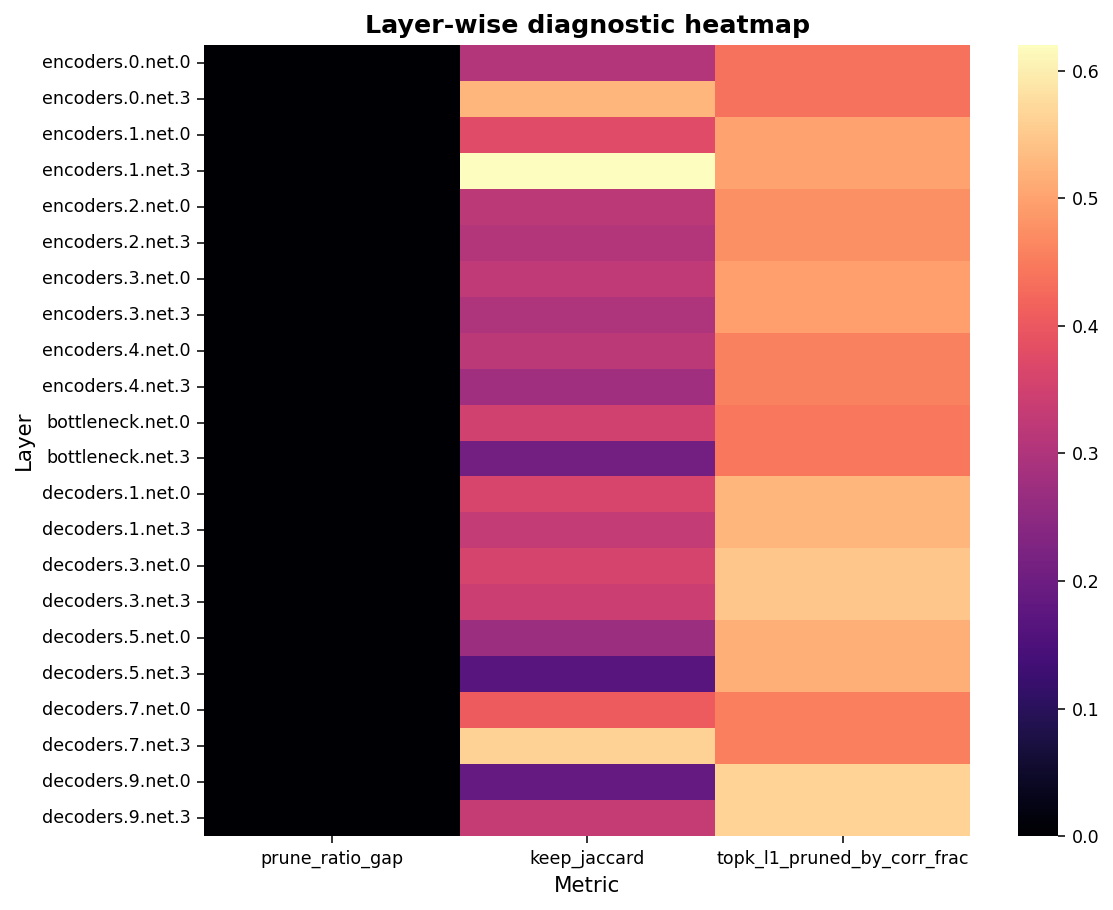

In [44]:
# 1) Heatmap: layer x metric
heat_df = valid[['layer','prune_ratio_gap','keep_jaccard','topk_l1_pruned_by_corr_frac']].set_index('layer')

try:
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(8.5, max(5.5, len(heat_df) * 0.30)))
    sns.heatmap(heat_df, annot=False, cmap='magma', cbar=True, linewidths=0, linecolor=None, ax=ax)
    ax.set_title('Layer-wise diagnostic heatmap')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Layer')
    ax.grid(False)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'seaborn unavailable ({e}); using matplotlib fallback.')
    arr = heat_df.values
    fig, ax = plt.subplots(figsize=(8.5, max(5.5, len(heat_df) * 0.30)))
    im = ax.imshow(arr, aspect='auto', cmap='magma')
    ax.set_yticks(np.arange(len(heat_df.index)))
    ax.set_yticklabels(heat_df.index)
    ax.set_xticks(np.arange(len(heat_df.columns)))
    ax.set_xticklabels(heat_df.columns, rotation=45, ha='right')
    ax.set_title('Layer-wise diagnostic heatmap')
    ax.grid(False)
    fig.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
    plt.tight_layout()
    plt.show()


,layer,both_keep,both_prune,l1_only_keep,corr_only_keep
0,encoders.0.net.0,15,15,17,17
1,encoders.0.net.3,22,22,10,10
2,encoders.1.net.0,35,35,29,29
3,encoders.1.net.3,49,49,15,15
4,encoders.2.net.0,62,62,66,66
5,encoders.2.net.3,60,60,68,68
6,encoders.3.net.0,125,125,131,131
7,encoders.3.net.3,118,118,138,138
8,encoders.4.net.0,124,124,132,132
9,encoders.4.net.3,111,111,145,145


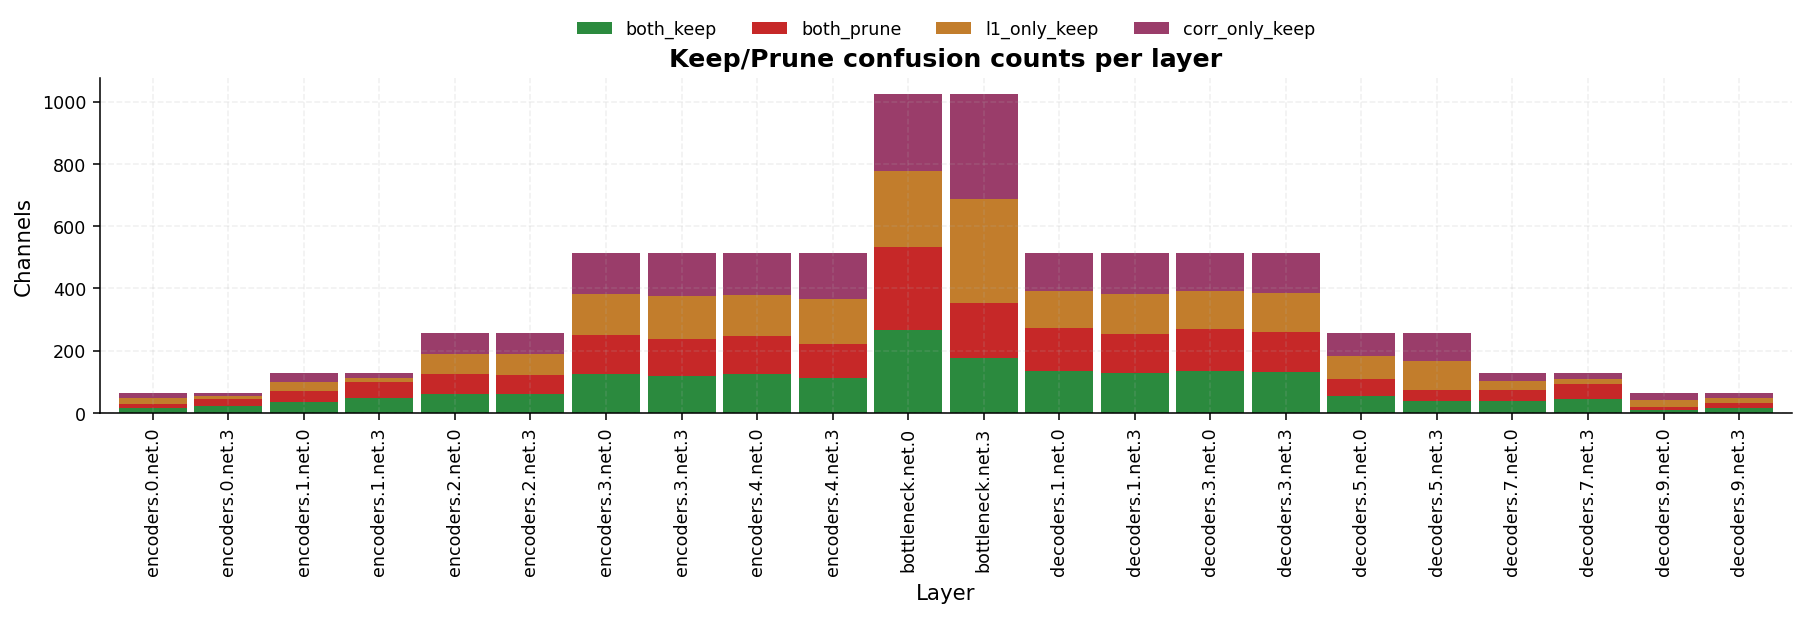

In [45]:
# 2) Keep/prune confusion counts per layer
rows = []
for _, r in valid.iterrows():
    layer = r['layer']
    l1 = l1_masks[layer].cpu().numpy().astype(bool)
    corr = corr_masks[layer].cpu().numpy().astype(bool)
    rows.append({
        'layer': layer,
        'both_keep': int((l1 & corr).sum()),
        'both_prune': int((~l1 & ~corr).sum()),
        'l1_only_keep': int((l1 & ~corr).sum()),
        'corr_only_keep': int((~l1 & corr).sum()),
    })
conf_df = pd.DataFrame(rows)
display(conf_df.head(10))

plot_df = conf_df.set_index('layer')[['both_keep','both_prune','l1_only_keep','corr_only_keep']]
colors = [PUB_COLORS['good'], PUB_COLORS['warn'], PUB_COLORS['neutral'], PUB_COLORS['corr']]
ax = plot_df.plot(kind='bar', stacked=True, figsize=(13, 4.8), color=colors, width=0.9)
ax.set_title('Keep/Prune confusion counts per layer')
ax.set_ylabel('Channels')
ax.set_xlabel('Layer')
ax.legend(frameon=False, ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.22))
_despine(ax)
plt.tight_layout()
plt.show()


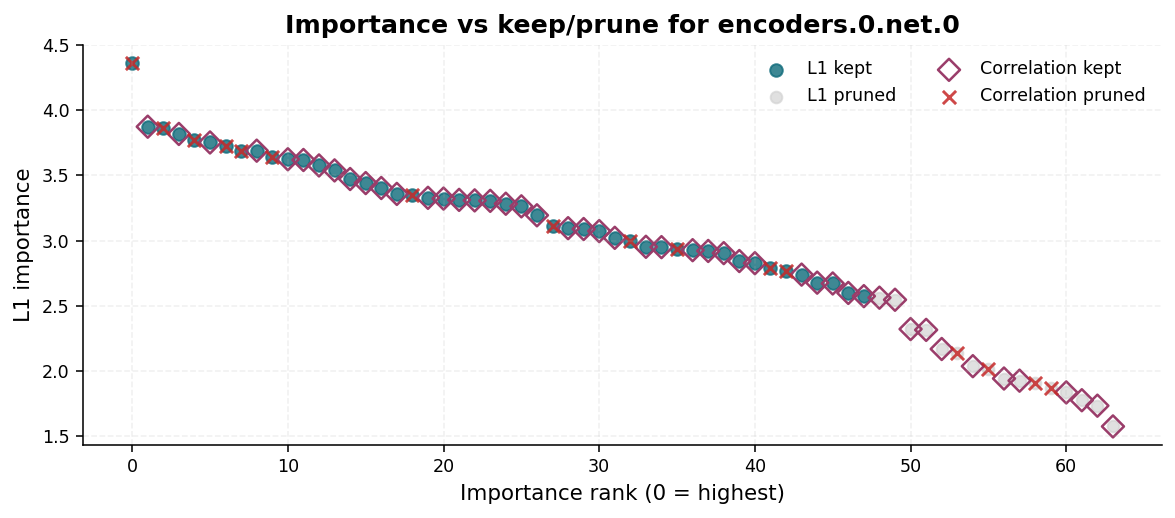

In [23]:
# 3) L1 importance rank vs kept/pruned scatter
layer_pick = valid.sort_values('prune_ratio_gap', ascending=False).iloc[0]['layer']
w_key = layer_pick + '.weight'

if w_key not in baseline_sd:
    raise KeyError(f'{w_key} not found in baseline state_dict')

w = baseline_sd[w_key].detach().cpu().numpy()
imp = np.abs(w).reshape(w.shape[0], -1).sum(axis=1)
rank = np.argsort(np.argsort(-imp))
l1_keep = l1_masks[layer_pick].cpu().numpy().astype(bool)
corr_keep = corr_masks[layer_pick].cpu().numpy().astype(bool)
assert len(imp) == len(l1_keep) == len(corr_keep), f'Mismatch: imp={len(imp)}, l1={len(l1_keep)}, corr={len(corr_keep)}'

fig, ax = plt.subplots(figsize=(8.5,3.8))
ax.scatter(rank[l1_keep], imp[l1_keep], color=PUB_COLORS['l1'], alpha=0.8, s=42, marker='o', label='L1 kept')
ax.scatter(rank[~l1_keep], imp[~l1_keep], color='lightgray', alpha=0.7, s=36, marker='o', label='L1 pruned')
ax.scatter(rank[corr_keep], imp[corr_keep], facecolors='none', edgecolors=PUB_COLORS['corr'], s=64, linewidths=1.3, marker='D', label='Correlation kept')
ax.scatter(rank[~corr_keep], imp[~corr_keep], marker='x', color=PUB_COLORS['warn'], alpha=0.85, s=46, label='Correlation pruned')
ax.set_xlabel('Importance rank (0 = highest)')
ax.set_ylabel('L1 importance')
ax.set_title(f'Importance vs keep/prune for {layer_pick}')
ax.legend(frameon=False, ncol=2)
_despine(ax)
plt.tight_layout()
plt.show()


,layer,retained_importance_l1,retained_importance_corr
0,encoders.0.net.0,0.588708,0.480467
1,encoders.0.net.3,0.643660,0.584524
2,encoders.1.net.0,0.613800,0.503193
3,encoders.1.net.3,0.596276,0.563684
4,encoders.2.net.0,0.615468,0.485799
5,encoders.2.net.3,0.631246,0.502833
6,encoders.3.net.0,0.588520,0.501372
7,encoders.3.net.3,0.574117,0.495500
8,encoders.4.net.0,0.566150,0.503096
9,encoders.4.net.3,0.588810,0.484310


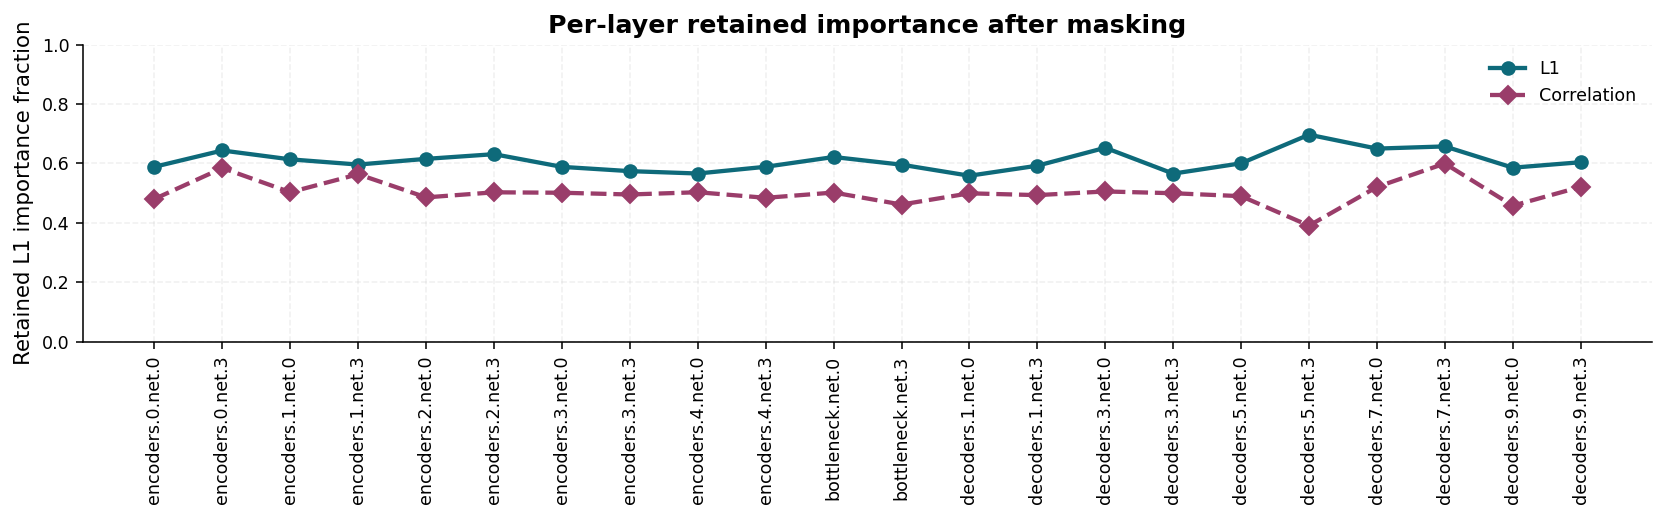

In [46]:
# 4) Retained importance curve per layer
curves = []
for _, r in valid.iterrows():
    layer = r['layer']
    w_key = layer + '.weight'
    if w_key not in baseline_sd:
        continue
    w = baseline_sd[w_key].detach().cpu().numpy()
    imp = np.abs(w).reshape(w.shape[0], -1).sum(axis=1)
    imp_total = imp.sum() + 1e-12
    l1_keep = l1_masks[layer].cpu().numpy().astype(bool)
    corr_keep = corr_masks[layer].cpu().numpy().astype(bool)
    if len(imp) != len(l1_keep) or len(imp) != len(corr_keep):
        print(f'Skipping {layer}: imp={len(imp)}, l1={len(l1_keep)}, corr={len(corr_keep)}')
        continue
    curves.append({
        'layer': layer,
        'retained_importance_l1': float(imp[l1_keep].sum() / imp_total),
        'retained_importance_corr': float(imp[corr_keep].sum() / imp_total),
    })
curves_df = pd.DataFrame(curves)
display(curves_df.head(10))

x = np.arange(len(curves_df))
fig, ax = plt.subplots(figsize=(12,3.8))
ax.plot(x, curves_df['retained_importance_l1'], marker='o', ms=6.5, lw=2.2, linestyle='-', color=PUB_COLORS['l1'], label='L1')
ax.plot(x, curves_df['retained_importance_corr'], marker='D', ms=6.5, lw=2.2, linestyle='--', color=PUB_COLORS['corr'], label='Correlation')
ax.set_xticks(x)
ax.set_xticklabels(curves_df['layer'], rotation=90)
ax.set_ylim(0,1)
ax.set_ylabel('Retained L1 importance fraction')
ax.set_title('Per-layer retained importance after masking')
ax.legend(frameon=False)
_despine(ax)
plt.tight_layout()
plt.show()


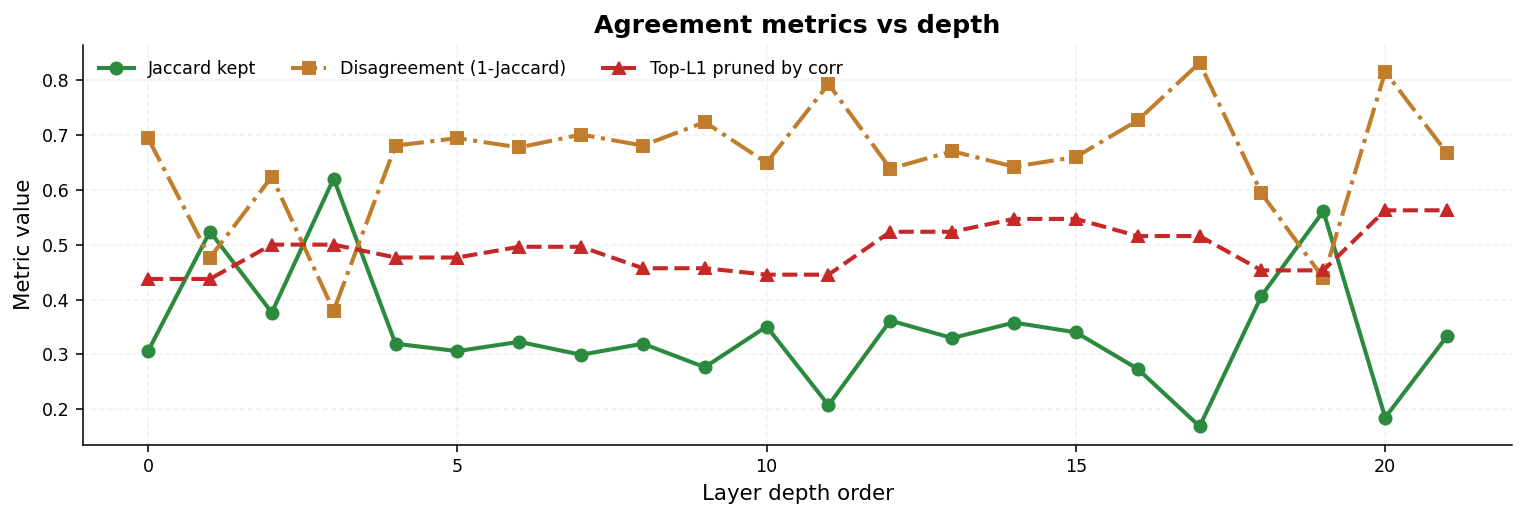

In [47]:
# 5) Agreement vs depth
depth_df = valid[['layer','keep_jaccard','disagreement','topk_l1_pruned_by_corr_frac']].reset_index(drop=True)
depth_df['depth'] = np.arange(len(depth_df))

fig, ax = plt.subplots(figsize=(11,3.8))
ax.plot(depth_df['depth'], depth_df['keep_jaccard'], marker='o', ms=6.2, lw=2.1, linestyle='-', color=PUB_COLORS['good'], label='Jaccard kept')
ax.plot(depth_df['depth'], depth_df['disagreement'], marker='s', ms=6.2, lw=2.1, linestyle='-.', color=PUB_COLORS['neutral'], label='Disagreement (1-Jaccard)')
ax.plot(depth_df['depth'], depth_df['topk_l1_pruned_by_corr_frac'], marker='^', ms=6.4, lw=2.1, linestyle='--', color=PUB_COLORS['warn'], label='Top-L1 pruned by corr')
ax.set_xlabel('Layer depth order')
ax.set_ylabel('Metric value')
ax.set_title('Agreement metrics vs depth')
ax.legend(frameon=False, ncol=3)
_despine(ax)
plt.tight_layout()
plt.show()


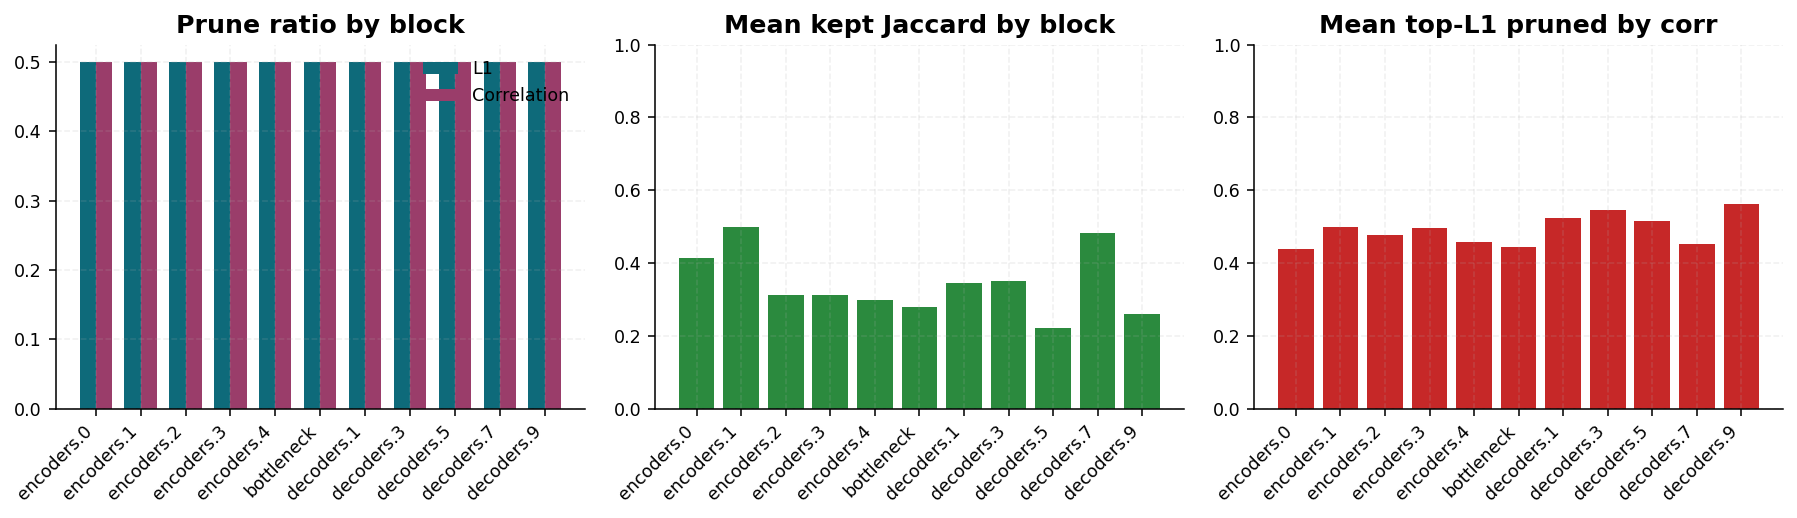

In [48]:
# 6) Block-level grouped bar chart
if 'block_df' not in globals():
    block_df = valid.groupby('block', as_index=False).agg(
        total=('total','sum'),
        keep_l1=('keep_l1','sum'),
        keep_corr=('keep_corr','sum'),
        prune_l1=('prune_l1','sum'),
        prune_corr=('prune_corr','sum'),
        keep_jaccard_mean=('keep_jaccard','mean'),
        topk_l1_pruned_by_corr_frac_mean=('topk_l1_pruned_by_corr_frac','mean'),
    )
    block_df['prune_ratio_l1'] = block_df['prune_l1'] / block_df['total']
    block_df['prune_ratio_corr'] = block_df['prune_corr'] / block_df['total']

block_order = [f'encoders.{i}' for i in range(20)] + ['bottleneck'] + [f'decoders.{i}' for i in range(40)]
b = block_df.copy()
b['block_order'] = b['block'].map(lambda x: block_order.index(x) if x in block_order else 999)
b = b.sort_values(['block_order', 'block']).reset_index(drop=True)

x = np.arange(len(b)); w = 0.36
fig, axes = plt.subplots(1, 3, figsize=(13,3.8))
axes[0].bar(x-w/2, b['prune_ratio_l1'], width=w, color=PUB_COLORS['l1'], label='L1')
axes[0].bar(x+w/2, b['prune_ratio_corr'], width=w, color=PUB_COLORS['corr'], label='Correlation')
axes[0].set_title('Prune ratio by block')
axes[0].legend(frameon=False)
axes[1].bar(x, b['keep_jaccard_mean'], color=PUB_COLORS['good'])
axes[1].set_ylim(0,1)
axes[1].set_title('Mean kept Jaccard by block')
axes[2].bar(x, b['topk_l1_pruned_by_corr_frac_mean'], color=PUB_COLORS['warn'])
axes[2].set_ylim(0,1)
axes[2].set_title('Mean top-L1 pruned by corr')
for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(b['block'], rotation=45, ha='right')
    _despine(ax)
plt.tight_layout()
plt.show()
